In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.special import rel_entr
import lightning as L
from torch.utils.data import Dataset, DataLoader
from torch.nn import ReLU, Tanh
from NCP.nn.layers import MLP
from NCP.utils import frnp, RegressionDataset
from NCP.nn.losses import CMELoss
from NCP.model import NCPOperator, NCPModule

from NCP.cde_fork.density_simulation import LinearGaussian, ArmaJump, SkewNormal, EconDensity, GaussianMixture, JumpDiffusionModel
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)  

Ntrain = 1000
Nval = 1000
Ntest = 100

In [3]:
def pdf2cdf(pdf, step):
    return np.cumsum(pdf * step, -1)

def normalize(x):
    return x/x.sum()

def empirical_KL(model, X, ys):
    scores = []
    for x in tqdm(X, total=len(X)):
        fys, pred_pdf = model.pdf(x[..., None], ys, postprocess='whitening', p_y=p_y)
        fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

        # true_pdf = density_simulator.pdf(x, yscaler.inverse_transform(y).T)
        true_pdf = norm.pdf(fys, loc=xscaler.inverse_transform(x[..., None]), scale=sigma_sq)
        
        pred_pdf = normalize(pred_pdf)
        true_pdf = normalize(true_pdf)
        
        scores.append(KL(true_pdf, pred_pdf))
    return scores

def empirical_H(model, X, ys):
    scores = []
    for x in tqdm(X, total=len(X)):
        fys, pred_pdf = model.pdf(x[..., None], ys, postprocess='whitening', p_y=p_y)
        fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

        true_pdf = norm.pdf(fys, loc=xscaler.inverse_transform(x[..., None]), scale=sigma_sq)
        
        scores.append(hellinger(true_pdf, pred_pdf))
    return scores


def KL(p, q):
    eps = np.finfo(p.dtype).eps
    p = np.where(p < eps, eps, p)
    q = np.where(q < eps, eps, q)
    
    p = normalize(p)
    q = normalize(q)
    
    return np.sum(rel_entr(p, q))

class XYDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    
    def __getitems__(self, idx_list):
        return self.X[idx_list], self.Y[idx_list]
    
# Class for preventing the wall of text
# https://github.com/Lightning-AI/pytorch-lightning/issues/15283
class LitProgressBar(L.pytorch.callbacks.TQDMProgressBar):
    def init_validation_tqdm(self):
        # bar = super().init_validation_tqdm()
        bar = tqdm(disable=True,)
        # bar.disable = True
        return bar

    def init_train_tqdm(self):
        bar = tqdm()
        bar.dynamic_ncols = False
        bar.ncols = 0
        bar.bar_format ='{desc} [{rate_fmt}{postfix}]'
        return bar

## Linear gaussian

In [ ]:
L.seed_everything(0)

X = np.random.normal(0, 1, Ntrain+Nval+Ntest)
from math import sqrt
sigma_sq = .5
Y = X + np.random.normal(2, sigma_sq, X.shape[0])

p_x = lambda x: (1/sqrt(2*np.pi)) * np.exp(-(x**2)/2)
p_y = lambda y: (1/(sqrt(2*np.pi)*sqrt(1+sigma_sq))) * np.exp(-(y**2)/(2*(1+sigma_sq)))

X = X.reshape((-1, 1))
Y = Y.reshape((-1, 1))

xscaler = StandardScaler()
yscaler = StandardScaler()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=Ntest, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=Nval, random_state=0)

X_train = xscaler.fit_transform(X_train)
Y_train = yscaler.fit_transform(Y_train)
X_test = xscaler.transform(X_test)
Y_test = yscaler.transform(Y_test)
X_val = xscaler.transform(X_val)
Y_val = yscaler.transform(Y_val)

In [ ]:
plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

In [ ]:
L.seed_everything(0)

lr = 1e-4
gamma = 1e-3
epochs = int(1e3)

MLP_kwargs = {
    'input_shape': X_train.shape[-1],
    'output_shape': 100,
    'n_hidden': 2,
    'layer_size': 256,
    'dropout': 0,
    'iterative_whitening': False
}

optimizer = Adam
optimizer_kwargs = {
    'lr': lr
    }

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': gamma
}

NCP_model = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs, V_operator_kwargs=MLP_kwargs)

X_train_torch = frnp(X_train)
Y_train_torch = frnp(Y_train)
X_val_torch = frnp(X_val)
Y_val_torch = frnp(Y_val)

NCP_module = NCPModule(
    NCP_model,
    optimizer,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs
)

train_dl = DataLoader(XYDataset(X_train_torch, Y_train_torch), batch_size=len(X_train_torch), shuffle=False, num_workers=0)
val_dl = DataLoader(XYDataset(X_val_torch, Y_val_torch), batch_size=len(X_val_torch), shuffle=False, num_workers=0)

trainer = L.Trainer(**{
    'accelerator': 'auto',
    'max_epochs': epochs,
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
    'enable_checkpointing': False,
    'num_sanity_val_steps': 0,
    'enable_model_summary': False,
}, callbacks=[LitProgressBar()])

In [ ]:
trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

In [ ]:
plt.figure(figsize=(17, 8))
plt.plot(range(len(NCP_module.train_loss)), np.array(NCP_module.train_loss))
plt.plot(range(len(NCP_module.val_loss)), np.array(NCP_module.val_loss), alpha=0.3)
# plt.yscale('log')
plt.show()

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

ax=axs[0]
pred = NCP_model.conditional_expectation(frnp(X_test), frnp(Y_train)).reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('No postprocessing')

ax=axs[1]
pred = NCP_model.conditional_expectation(frnp(X_test), frnp(Y_train), postprocess='centering').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With centering')

ax=axs[2]
pred = NCP_model.conditional_expectation(frnp(X_test), frnp(Y_train), postprocess='whitening').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With whitening')

plt.legend()
plt.show()

In [ ]:
from scipy.stats import norm
from NCP.cdf import compute_marginal
from NCP.metrics import *

p10, p90 = np.percentile(X_train, [10, 90])
x_grid = np.linspace(p10, p90, num=4)
p1, p99 = np.percentile(X_train, [1, 99])
ys, step = np.linspace(p1, p99, num=1000, retstep=True)
ys = frnp(ys.reshape(-1, 1))

p_y = compute_marginal(bandwidth='scott').fit(Y_train)

fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(15,5))
axes = ax.flatten()
postprocess = 'whitening'
for i, xi in enumerate(x_grid):
    fys, pred_pdf = NCP_model.pdf(frnp([[xi]]), ys, p_y=p_y, postprocess=postprocess)
    fys = fys.reshape(-1, 1)
    true_pdf = norm.pdf(yscaler.inverse_transform(fys), loc=xscaler.inverse_transform([[xi]])+2, scale=sigma_sq)
    true_cdf = norm.cdf(yscaler.inverse_transform(fys), loc=xscaler.inverse_transform([[xi]])+2, scale=sigma_sq)
    axes[i*3].plot(yscaler.inverse_transform(fys), true_pdf.squeeze())
    axes[i*3].plot(yscaler.inverse_transform(fys), pred_pdf.squeeze())
    # axes[i*3].axvline(xscaler.inverse_transform([[xi]]), color='red')

    pred_cdf = pdf2cdf(pred_pdf, step)
    fys2, pred_cdf2 = NCP_model.cdf(frnp([[xi]]), frnp(Y_train), postprocess=postprocess)
    fys2 = fys2.reshape(-1, 1)
    true_cdf2 = norm.cdf(yscaler.inverse_transform(fys2), loc=xscaler.inverse_transform([[xi]])+2, scale=sigma_sq)
    axes[i*3+1].plot(yscaler.inverse_transform(fys), true_cdf.squeeze())
    axes[i*3+1].plot(yscaler.inverse_transform(fys), pred_cdf.squeeze())
    axes[i*3+2].plot(yscaler.inverse_transform(fys2), true_cdf2.squeeze())
    axes[i*3+2].plot(yscaler.inverse_transform(fys2), pred_cdf2.squeeze())

    # h_pdf, h_cdf = hellinger(true_cdf, pred_cdf, fys)
    # h_pdf2, h_cdf2 = hellinger(true_cdf2, pred_cdf2, fys2)
    # 
    # axes[i*3].set_title(r'x = {0}; H = {1:0.4f}'.format(xi, h_pdf))
    # axes[i*3+1].set_title(r'x = {0}; H = {1:0.4f}'.format(xi, h_cdf))
    # axes[i*3+2].set_title(r'x = {0}; H = {1:0.4f}'.format(xi, h_cdf2))

plt.tight_layout()
plt.show()

In [ ]:
from NCP.metrics import compute_metrics
from scipy.stats import norm
from NCP.cdf import compute_marginal
p_y = compute_marginal(bandwidth='scott').fit(Y_train)

p10, p90 = np.percentile(X_train, [10, 90])
x_grid = np.linspace(p10, p90, num=5)
ys, step = np.linspace(-2, 2, num=1000, retstep=True)
ys = frnp(ys.reshape(-1, 1))

postprocess = 'whitening'
scores = []
for xi in x_grid:
    fys, pred_pdf = NCP_model.pdf(frnp([[xi]]), ys, p_y=p_y, postprocess=postprocess)
    fys = fys.reshape(-1, 1)
    true_pdf = norm.pdf(yscaler.inverse_transform(fys), loc=xscaler.inverse_transform([[xi]])+2, scale=sigma_sq)
    true_cdf = norm.cdf(yscaler.inverse_transform(fys), loc=xscaler.inverse_transform([[xi]])+2, scale=sigma_sq)
    pred_cdf = pdf2cdf(pred_pdf, step)
    
    result = compute_metrics(true_cdf.squeeze(), pred_cdf.squeeze(), metrics='all', smooth=True, values=fys.squeeze())
    result['x'] = xi
    
    scores.append(result)

In [ ]:
scores = pd.DataFrame(scores)
print(scores.median())

In [ ]:
n_training_samples = [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
lr = 1e-4
gamma = 1e-3
epochs = int(1e4)
models = []
for seed in range(5):
    for n in n_training_samples:
        print(f'Running with {n} samples - seed {seed}')
        L.seed_everything(seed)
        sigma_sq = .5
        X = np.random.normal(0, 1, n+1000)
        Y = X + np.random.normal(0, sigma_sq, X.shape[0])
    
        X = X.reshape((-1, 1))
        Y = Y.reshape((-1, 1))
        
        xscaler = StandardScaler()
        yscaler = StandardScaler()
        
        X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=1000)
        
        X_train = xscaler.fit_transform(X_train)
        Y_train = yscaler.fit_transform(Y_train)
        X_test = xscaler.transform(X_test)
        Y_test = yscaler.transform(Y_test)
        X_val = xscaler.transform(X_val)
        Y_val = yscaler.transform(Y_val)
    
        X_train_torch = frnp(X_train)
        Y_train_torch = frnp(Y_train)
        X_val_torch = frnp(X_val)
        Y_val_torch = frnp(Y_val)
    
        NCP_model = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs, V_operator_kwargs=MLP_kwargs)
    
        optimizer = Adam
        optimizer_kwargs = {
            'lr': lr
            }
    
        NCP_module = NCPModule(
            NCP_model,
            optimizer,
            optimizer_kwargs,
            CMELoss,
            loss_kwargs
        )
        
        train_dl = DataLoader(XYDataset(X_train_torch, Y_train_torch), batch_size=len(X_train_torch), shuffle=False, num_workers=0)
        val_dl = DataLoader(XYDataset(X_val_torch, Y_val_torch), batch_size=len(X_val_torch), shuffle=False, num_workers=0)
    
        trainer = L.Trainer(**{
            'accelerator': 'auto',
            'max_epochs': epochs,
            'log_every_n_steps': 0,
            'enable_progress_bar': False,
            'devices': 1,
            'enable_checkpointing': False,
            'num_sanity_val_steps': 0,
            'enable_model_summary': False,
        })
        
        trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)
        
        models.append({
            'n_samples': n,
            'seed': seed,
            'model': [NCP_module]
        })
    
models_df = pd.DataFrame(models)
models_df.to_pickle('linear_gaussian_models.pkl')

In [ ]:
models_df

In [ ]:
results = []
for row in tqdm(models_df.iterrows(), total=len(models_df), desc='Evaluating models'):
    n = row[1]['n_samples']
    model = row[1]['model'][0].model
    p10, p90 = np.percentile(X_train, [10, 90])
    x_grid = np.linspace(p10, p90, num=20)
    ys, step = np.linspace(-3, 3, num=1000, retstep=True)
    ys = frnp(ys.reshape(-1, 1))

    for postprocess in [None, 'centering', 'whitening']:
        scores_pdf = []
        scores_cdf = []
        for el in x_grid:
            x_scaled = frnp([[el]])
            fys, pred_pdf = model.pdf(x_scaled, ys, postprocess=postprocess, p_y=p_y)
            fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()
            true_pdf = norm.pdf(fys, loc=xscaler.inverse_transform([[el]]), scale=sigma_sq).squeeze()
            pred_cdf = pdf2cdf(pred_pdf, step)
            true_cdf = norm.cdf(fys, loc=xscaler.inverse_transform([[el]]), scale=sigma_sq).squeeze()
            scores_pdf.append(hellinger(true_pdf, pred_pdf, fys))
            scores_cdf.append(hellinger(true_cdf, pred_cdf, fys))

        result = {
            'n_samples': n,
            'postprocess': str(postprocess),
            'scores_pdf': scores_pdf,
            'scores_cdf': scores_cdf
        }
        results.append(result)

In [ ]:
results_df = pd.DataFrame(results)
results_df.to_pickle('linear_gaussian.pkl')

In [ ]:
results_df

In [ ]:
results_df = pd.read_pickle('linear_gaussian.pkl')
#take results_pd, group by n_samples and postprocess, apply np.mean and np.std to scores_pdf and create a new dataframe with the results
grouped_results= pd.DataFrame(results_df.groupby(['n_samples', 'postprocess'])['scores_cdf'].apply(lambda x: np.mean(list(x))))
grouped_results.rename(columns={'scores_cdf': 'mean_scores_cdf'}, inplace=True)
grouped_results['std_scores_cdf'] = results_df.groupby(['n_samples', 'postprocess'])['scores_cdf'].apply(lambda x: np.std(list(x)))
grouped_results['mean_scores_pdf'] = results_df.groupby(['n_samples', 'postprocess'])['scores_pdf'].apply(lambda x: np.mean(list(x)))
grouped_results['std_scores_pdf'] = results_df.groupby(['n_samples', 'postprocess'])['scores_pdf'].apply(lambda x: np.std(list(x)))
grouped_results = grouped_results.reset_index()
print(grouped_results)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for postprocess in ['None', 'centering', 'whitening']:
    ax = axs[0]
    n_samples = grouped_results[grouped_results['postprocess'] == postprocess]['n_samples']
    mean_score = grouped_results[grouped_results['postprocess'] == postprocess]['mean_scores_pdf']
    std_score = grouped_results[grouped_results['postprocess'] == postprocess]['std_scores_pdf']
    ax.plot(n_samples, mean_score, label=postprocess)
    ax.fill_between(n_samples, mean_score - std_score, mean_score + std_score, alpha=0.3)
    ax.set_title('Average PDF Hellinger distance')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of training samples')

    ax = axs[1]
    mean_score = grouped_results[grouped_results['postprocess'] == postprocess]['mean_scores_cdf']
    std_score = grouped_results[grouped_results['postprocess'] == postprocess]['std_scores_cdf']
    ax.plot(n_samples, mean_score, label=postprocess)
    ax.fill_between(n_samples, mean_score - std_score, mean_score + std_score, alpha=0.3)
    ax.set_title('Average CDF Hellinger distance')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of training samples')

plt.legend()
plt.show()

## ECON 

In [4]:
sigma_sq = 1

Ntrain = int(1000)
Nval = int(1e3)
Ntest = int(1e2)

density_simulator = EconDensity(std= sigma_sq, heteroscedastic=True, random_seed=42)
X, Y = density_simulator.simulate(n_samples = Ntrain+Nval+Ntest)

X = X.reshape((-1, 1))
Y = Y.reshape((-1, 1))

xscaler = StandardScaler()
yscaler = StandardScaler()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=Ntest, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=Nval, random_state=0)

X_train = xscaler.fit_transform(X_train)
Y_train = yscaler.fit_transform(Y_train)
X_test = xscaler.transform(X_test)
Y_test = yscaler.transform(Y_test)
X_val = xscaler.transform(X_val)
Y_val = yscaler.transform(Y_val)

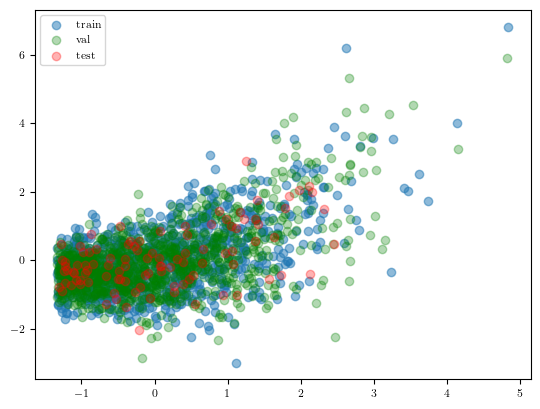

In [5]:
plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

In [6]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

class MyEarlyStopping(EarlyStopping):

    def on_train_end(self, trainer, pl_module):
        # instead, do it at the end of training loop
        self._run_early_stopping_check(trainer)

In [7]:
L.seed_everything(0)

lr = 1e-4
gamma = 1e-3
epochs = int(2e3)

MLP_kwargs = {
    'input_shape': X_train.shape[-1],
    'output_shape': 100,
    'n_hidden': 2,
    'layer_size': 32,
    'dropout': 0,
    'iterative_whitening': False,
    'activation': Tanh
}

optimizer = Adam
optimizer_kwargs = {
    'lr': lr
    }

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': gamma
}

NCP_model = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs, V_operator_kwargs=MLP_kwargs)

X_train_torch = frnp(X_train)
Y_train_torch = frnp(Y_train)
X_val_torch = frnp(X_val)
Y_val_torch = frnp(Y_val)

NCP_module = NCPModule(
    NCP_model,
    optimizer,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs
)

train_dl = DataLoader(XYDataset(X_train_torch, Y_train_torch), batch_size=len(X_train_torch), shuffle=False, num_workers=0)
val_dl = DataLoader(XYDataset(X_val_torch, Y_val_torch), batch_size=len(X_val_torch), shuffle=False, num_workers=0)

trainer = L.Trainer(**{
    'accelerator': 'auto',
    'max_epochs': epochs,
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
    'enable_checkpointing': False,
    'num_sanity_val_steps': 0,
    'enable_model_summary': True,
}, callbacks=[LitProgressBar(), EarlyStopping(monitor='train_loss', mode='min', patience=200)])

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 8.7 K 
--------------------------------------
8.7 K     Trainable params
0         Non-trainable params
8.7 K     Total params
0.035     Total estimated model params size (MB)


0it [00:00, ?it/s]

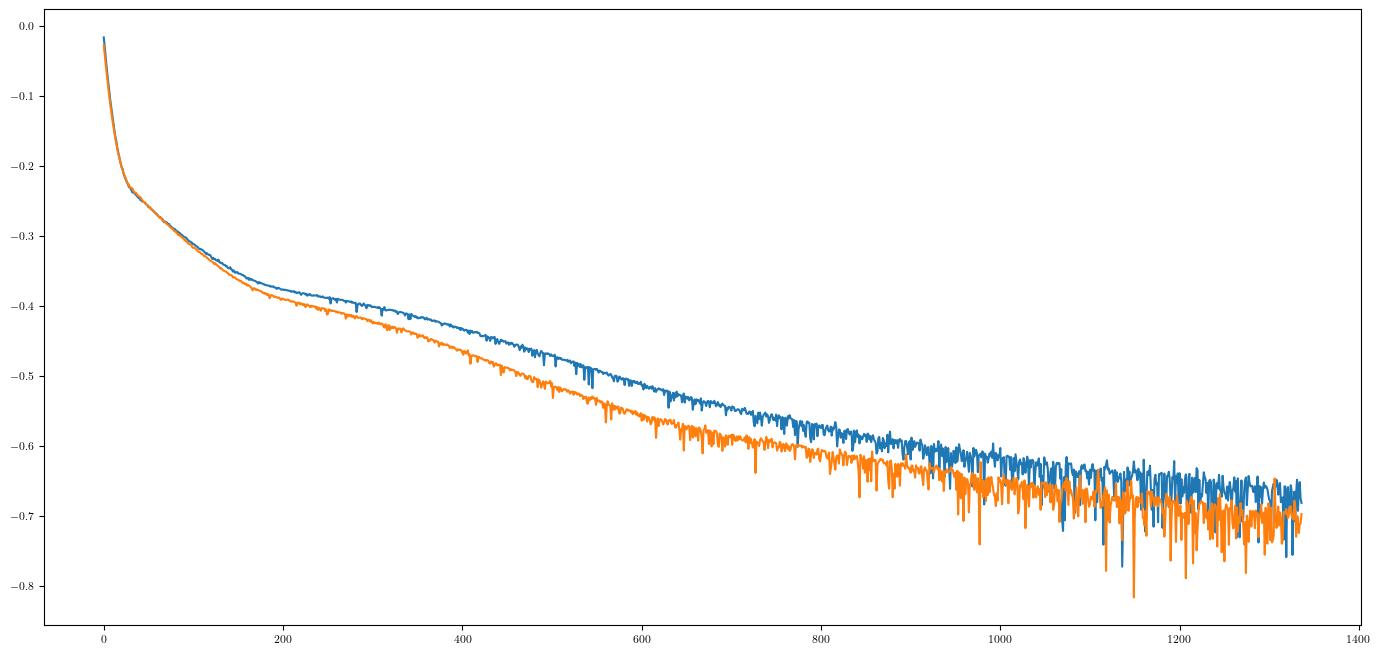

In [9]:
plt.figure(figsize=(17, 8))
plt.plot(range(len(NCP_module.train_loss)), np.array(NCP_module.train_loss))
plt.plot(range(len(NCP_module.val_loss)), np.array(NCP_module.val_loss))
# plt.yscale('log')
plt.show()

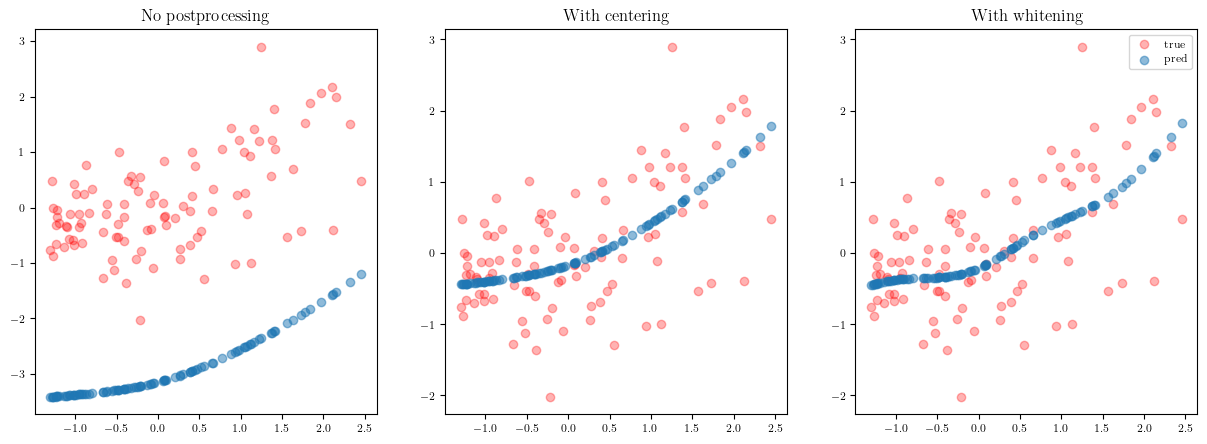

In [10]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

ax=axs[0]
pred = NCP_model.conditional_expectation(frnp(X_test), frnp(Y_train)).reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('No postprocessing')

ax=axs[1]
pred = NCP_model.conditional_expectation(frnp(X_test), frnp(Y_train), postprocess='centering').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With centering')

ax=axs[2]
pred = NCP_model.conditional_expectation(frnp(X_test), frnp(Y_train), postprocess='whitening').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With whitening')

plt.legend()
plt.show()

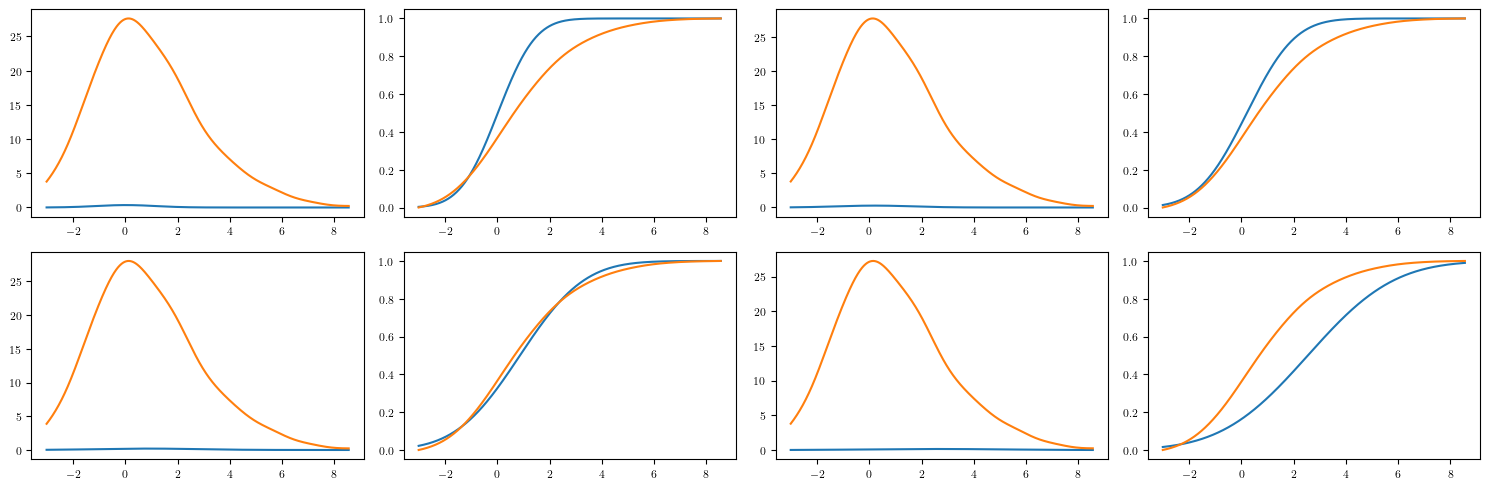

In [11]:
from NCP.cdf import compute_marginal
from NCP.metrics import *

x_grid = np.percentile(X_train, np.linspace(10, 90, num=4))
p1, p99 = np.percentile(Y_train, [1, 99])
ys, step = np.linspace(p1, p99, num=1000, retstep=True)
ys = frnp(ys.reshape(-1, 1))
p_y = compute_marginal(bandwidth='scott').fit(Y_train)

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,5))
axes = ax.flatten()
postprocess = None
for i, xi in enumerate(x_grid):
    fys, pred_pdf = NCP_model.pdf(frnp([[xi]]), frnp(ys), postprocess=postprocess, p_y=p_y)
    fys = fys.reshape(-1, 1)
    true_pdf = density_simulator.pdf(xscaler.inverse_transform([[xi]]), yscaler.inverse_transform(ys).T).squeeze()
    axes[i*2].plot(yscaler.inverse_transform(fys), true_pdf)
    axes[i*2].plot(yscaler.inverse_transform(fys), pred_pdf)

    pred_cdf = pdf2cdf(pred_pdf, step)
    true_cdf = density_simulator.cdf(xscaler.inverse_transform([[xi]]), yscaler.inverse_transform(ys).T).squeeze()
    axes[i*2+1].plot(yscaler.inverse_transform(fys), true_cdf)
    axes[i*2+1].plot(yscaler.inverse_transform(fys), smooth_cdf(fys, pred_cdf))

    # axes[i*2].set_title(r'x = {0}; H = {1:0.4f}'.format(xi, hellinger(true_pdf, pred_pdf, fys)))
    # axes[i*2+1].set_title(r'x = {0}; H = {1:0.4f}'.format(xi, hellinger(true_cdf, pred_cdf, fys)))

plt.tight_layout()
plt.show()

In [18]:
x_grid = np.percentile(X_train, np.linspace(10, 90, num=10))
p1, p99 = np.percentile(Y_train, [1, 99])
ys, step = np.linspace(p1, p99, num=1000, retstep=True)
ys = frnp(ys.reshape(-1, 1))

postprocess = 'centering'
scores = []
for xi in x_grid:
    fys, pred_pdf = NCP_model.pdf(frnp([[xi]]), frnp(ys), postprocess=postprocess, p_y=p_y)
    pred_cdf = pdf2cdf(pred_pdf, step)
    true_cdf = density_simulator.cdf(xscaler.inverse_transform(np.ones_like(ys)*xi), yscaler.inverse_transform(ys)).squeeze()
    
    result = compute_metrics(true_cdf.squeeze(), pred_cdf.squeeze(), metrics='all', smooth=True, values=fys.squeeze())
    result['x'] = xi
    
    scores.append(result)

In [17]:
scores = pd.DataFrame(scores)
print(scores.mean())

hellinger             0.459113
wasserstein1          0.013644
kolmogorov_smirnov    0.038929
total_variation       6.821818
jensen_shannon_dv     0.228008
x                    -0.078691
dtype: float64


In [19]:
scores = pd.DataFrame(scores)
print(scores.mean())

hellinger             0.459113
wasserstein1          0.013644
kolmogorov_smirnov    0.038929
total_variation       6.821818
jensen_shannon_dv     0.228008
x                    -0.078691
dtype: float64


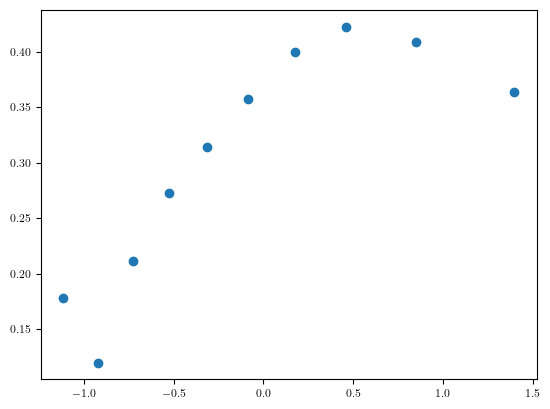

In [82]:
plt.scatter(x_grid.squeeze(), np.array(scores.hellinger))

In [16]:
n_training_samples = [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
lr = 1e-4
gamma = 1e-3
epochs = int(2e3)

models = []
for n in n_training_samples:
    print(f'Running with {n} samples')
    X, Y = density_simulator.simulate(n_samples = n+1000)
    X = X.reshape((-1, 1))
    Y = Y.reshape((-1, 1))
    xscaler = StandardScaler()
    yscaler = StandardScaler()
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=1000, random_state=0)
    X_train = xscaler.fit_transform(X_train)
    Y_train = yscaler.fit_transform(Y_train)
    X_val = xscaler.transform(X_val)
    Y_val = yscaler.transform(Y_val)

    X_train_torch = frnp(X_train)
    Y_train_torch = frnp(Y_train)
    X_val_torch = frnp(X_val)
    Y_val_torch = frnp(Y_val)

    optimizer_kwargs = {
        'lr': lr
        }

    NCP_module = NCPModule(
        NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs, V_operator_kwargs=MLP_kwargs),
        Adam,
        optimizer_kwargs,
        CMELoss,
        loss_kwargs
    )
    
    train_dl = DataLoader(XYDataset(X_train_torch, Y_train_torch), batch_size=len(X_train_torch), shuffle=False, num_workers=0)
    val_dl = DataLoader(XYDataset(X_val_torch, Y_val_torch), batch_size=len(X_val_torch), shuffle=False, num_workers=0)

    trainer = L.Trainer(**{
    'accelerator': 'cuda',
    'max_epochs': epochs,
    'log_every_n_steps': 0,
    'enable_progress_bar': False,
    'devices': 1,
    'enable_checkpointing': False,
    'num_sanity_val_steps': 0,
    'enable_model_summary': False,
    })
    
    trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)
    
    models.append({
        'n_samples': n,
        'model': [NCP_module]
    })
    
    #print last training and validation loss
    print('Training loss: {0}'.format(NCP_module.train_loss[-1]))
    print('Validation loss: {0}'.format(NCP_module.val_loss[-1]))

models_df = pd.DataFrame(models)
models_df.to_pickle('ECON_models.pkl')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Running with 100 samples


`Trainer.fit` stopped: `max_epochs=2000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training loss: -474.84686279296875
Validation loss: 437879.1875
Running with 200 samples


`Trainer.fit` stopped: `max_epochs=2000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training loss: -0.9750983715057373
Validation loss: -0.37467217445373535
Running with 500 samples


`Trainer.fit` stopped: `max_epochs=2000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training loss: -0.8423013687133789
Validation loss: -0.45760518312454224
Running with 1000 samples


`Trainer.fit` stopped: `max_epochs=2000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training loss: -0.7685520052909851
Validation loss: -0.673405110836029
Running with 2000 samples


`Trainer.fit` stopped: `max_epochs=2000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training loss: -205.2708740234375
Validation loss: -0.48184067010879517
Running with 5000 samples


`Trainer.fit` stopped: `max_epochs=2000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training loss: -1.0623928308486938
Validation loss: 0.6843346357345581
Running with 10000 samples


`Trainer.fit` stopped: `max_epochs=2000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training loss: -0.9165807962417603
Validation loss: -1.005994200706482
Running with 20000 samples


`Trainer.fit` stopped: `max_epochs=2000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training loss: -0.8062350749969482
Validation loss: -0.5680888295173645
Running with 50000 samples


`Trainer.fit` stopped: `max_epochs=2000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training loss: -0.91035395860672
Validation loss: -0.11999819427728653
Running with 100000 samples


`Trainer.fit` stopped: `max_epochs=2000` reached.


Training loss: -0.8796097636222839
Validation loss: -1.452436923980713


In [17]:
models_df = pd.read_pickle('ECON_models.pkl')

results = []
for row in tqdm(models_df.iterrows(), total=len(models_df), desc='Evaluating models'):
    n = row[1]['n_samples']
    model = row[1]['model'][0].model
    
    p10, p90 = np.percentile(X_train, [10, 90])
    x_grid = np.linspace(p10, p90, num=10)
    
    p10, p90 = np.percentile(Y_train, [1, 99])
    ys, step = np.linspace(p1, p99, num=1000, retstep=True)
    ys = frnp(ys.reshape(-1, 1))

    for postprocess in [None, 'centering', 'whitening']:
        scores = []
        for xi in x_grid:
            fys, pred_pdf = model.pdf(frnp([[xi]]), frnp(ys), postprocess=postprocess, p_y=p_y)
            pred_cdf = pdf2cdf(pred_pdf, step)
            true_cdf = density_simulator.cdf(xscaler.inverse_transform([[xi]]), yscaler.inverse_transform(ys).T).squeeze()
            
            computed_metrics = compute_metrics(true_cdf.squeeze(), pred_cdf.squeeze(), metrics='all', smooth=True, values=fys.squeeze())
            computed_metrics['x'] = xi
            
            scores.append(computed_metrics)

        result = {
            'n_samples': n,
            'postprocess': str(postprocess),
        }
        
        scores = pd.DataFrame(scores)
        for key in scores:
            result[key] = [scores[key].values]
        
        results.append(result)

Evaluating models:   0%|          | 0/10 [00:00<?, ?it/s]

In [19]:
results_df = pd.DataFrame(results)
results_df.to_pickle('ECON_results.pkl')

In [20]:
results_df = pd.read_pickle('ECON_results.pkl')
#take results_pd, group by n_samples and postprocess, apply np.mean and np.std to scores_pdf and create a new dataframe with the results
grouped_results= pd.DataFrame(results_df.groupby(['n_samples', 'postprocess'])['hellinger'].apply(lambda x: np.mean(list(x))))
grouped_results.rename(columns={'hellinger': 'mean_H'}, inplace=True)
grouped_results['median_H'] = results_df.groupby(['n_samples', 'postprocess'])['hellinger'].apply(lambda x: np.median(list(x)))
grouped_results['std_H'] = results_df.groupby(['n_samples', 'postprocess'])['hellinger'].apply(lambda x: np.std(list(x)))
grouped_results['mean_W1'] = results_df.groupby(['n_samples', 'postprocess'])['wasserstein1'].apply(lambda x: np.mean(list(x)))
grouped_results['median_W1'] = results_df.groupby(['n_samples', 'postprocess'])['wasserstein1'].apply(lambda x: np.median(list(x)))
grouped_results['std_W1'] = results_df.groupby(['n_samples', 'postprocess'])['wasserstein1'].apply(lambda x: np.std(list(x)))
grouped_results['mean_KS'] = results_df.groupby(['n_samples', 'postprocess'])['kolmogorov_smirnov'].apply(lambda x: np.mean(list(x)))
grouped_results['median_KS'] = results_df.groupby(['n_samples', 'postprocess'])['kolmogorov_smirnov'].apply(lambda x: np.median(list(x)))
grouped_results['std_KS'] = results_df.groupby(['n_samples', 'postprocess'])['kolmogorov_smirnov'].apply(lambda x: np.std(list(x)))
grouped_results['mean_TV'] = results_df.groupby(['n_samples', 'postprocess'])['total_variation'].apply(lambda x: np.mean(list(x)))
grouped_results['median_TV'] = results_df.groupby(['n_samples', 'postprocess'])['total_variation'].apply(lambda x: np.median(list(x)))
grouped_results['std_TV'] = results_df.groupby(['n_samples', 'postprocess'])['total_variation'].apply(lambda x: np.std(list(x)))
grouped_results['mean_JS'] = results_df.groupby(['n_samples', 'postprocess'])['jensen_shannon_dv'].apply(lambda x: np.mean(list(x)))
grouped_results['median_JS'] = results_df.groupby(['n_samples', 'postprocess'])['jensen_shannon_dv'].apply(lambda x: np.mean(list(x)))
grouped_results['std_JS'] = results_df.groupby(['n_samples', 'postprocess'])['jensen_shannon_dv'].apply(lambda x: np.std(list(x)))
grouped_results = grouped_results.reset_index()
print(grouped_results)

    n_samples postprocess    mean_H  median_H     std_H   mean_W1  median_W1  \
0         100        None  6.356673  6.203950  5.394078  0.277914   0.297970   
1         100   centering  1.337930  0.941908  0.905545  0.059619   0.039052   
2         100   whitening  1.422675  1.198086  0.734964  0.065073   0.063309   
3         200        None  1.247661  1.232026  0.531106  0.032378   0.026218   
4         200   centering  1.178454  1.168127  0.488797  0.029798   0.026325   
5         200   whitening  1.788100  1.572539  0.827190  0.047390   0.047536   
6         500        None  0.845823  0.905300  0.380237  0.019711   0.023413   
7         500   centering  0.847351  0.873904  0.367725  0.020572   0.022225   
8         500   whitening  1.210044  1.236580  0.446340  0.032724   0.035551   
9        1000        None  0.543673  0.545974  0.142458  0.014647   0.013298   
10       1000   centering  0.490342  0.494449  0.117542  0.012061   0.009554   
11       1000   whitening  0.846749  0.7

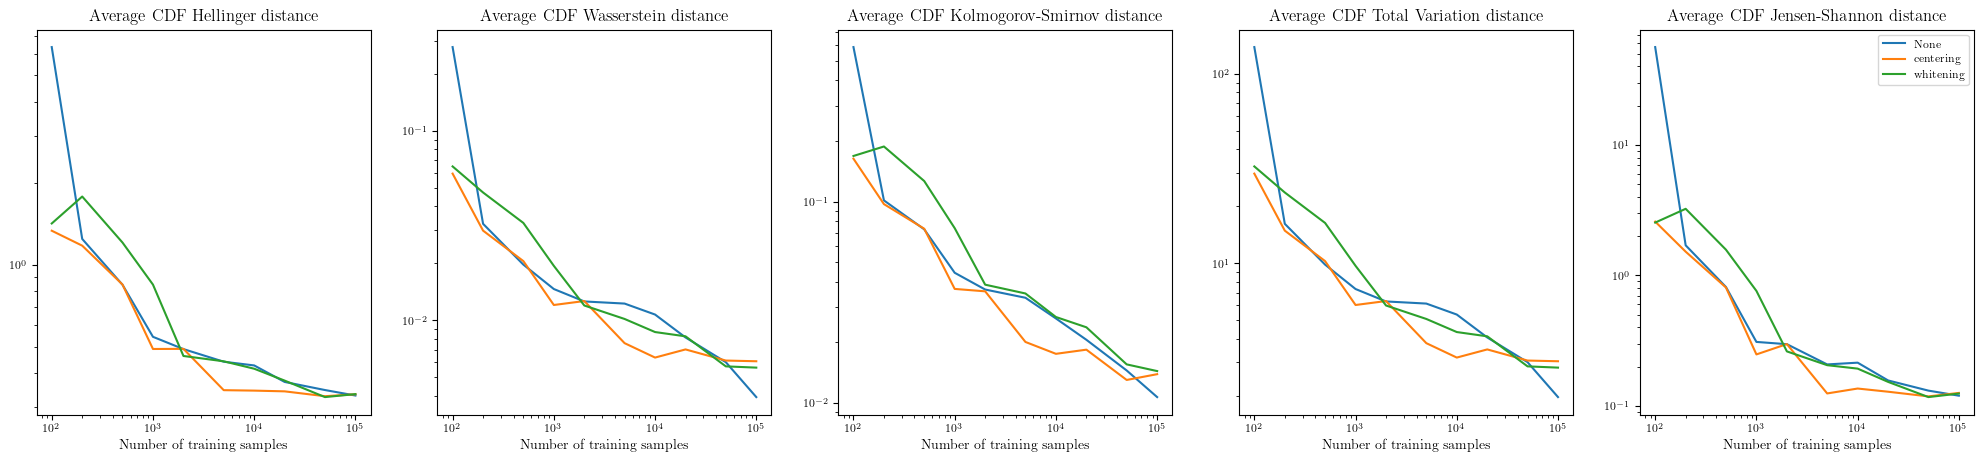

In [21]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))

for postprocess in ['None', 'centering', 'whitening']:
    ax = axs[0]
    n_samples = grouped_results[grouped_results['postprocess'] == postprocess]['n_samples']
    mean_score = grouped_results[grouped_results['postprocess'] == postprocess]['mean_H']
    std_score = grouped_results[grouped_results['postprocess'] == postprocess]['std_H']
    ax.plot(n_samples, mean_score, label=postprocess)
    # ax.fill_between(n_samples, mean_score - std_score, mean_score + std_score, alpha=0.2)
    ax.set_title('Average CDF Hellinger distance')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of training samples')

    ax = axs[1]
    mean_score = grouped_results[grouped_results['postprocess'] == postprocess]['mean_W1']
    std_score = grouped_results[grouped_results['postprocess'] == postprocess]['std_W1']
    ax.plot(n_samples, mean_score, label=postprocess)
    # ax.fill_between(n_samples, mean_score - std_score, mean_score + std_score, alpha=0.2)
    ax.set_title('Average CDF Wasserstein distance')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of training samples')
    
    ax = axs[2]
    mean_score = grouped_results[grouped_results['postprocess'] == postprocess]['mean_KS']
    std_score = grouped_results[grouped_results['postprocess'] == postprocess]['std_KS']
    ax.plot(n_samples, mean_score, label=postprocess)
    # ax.fill_between(n_samples, mean_score - std_score, mean_score + std_score, alpha=0.2)
    ax.set_title('Average CDF Kolmogorov-Smirnov distance')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of training samples')


    ax = axs[3]
    mean_score = grouped_results[grouped_results['postprocess'] == postprocess]['mean_TV']
    std_score = grouped_results[grouped_results['postprocess'] == postprocess]['std_TV']
    ax.plot(n_samples, mean_score, label=postprocess)
    # ax.fill_between(n_samples, mean_score - std_score, mean_score + std_score, alpha=0.2)
    ax.set_title('Average CDF Total Variation distance')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of training samples')

    ax = axs[4]
    mean_score = grouped_results[grouped_results['postprocess'] == postprocess]['mean_JS']
    std_score = grouped_results[grouped_results['postprocess'] == postprocess]['std_JS']
    ax.plot(n_samples, mean_score, label=postprocess)
    # ax.fill_between(n_samples, mean_score - std_score, mean_score + std_score, alpha=0.2)
    ax.set_title('Average CDF Jensen-Shannon distance')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of training samples')


plt.legend()
plt.show()

## ARMA Jump 

In [4]:
density_simulator = ArmaJump(random_seed=0)
X, Y = density_simulator.simulate(n_samples = Ntrain+Nval+Ntest)

X = X.reshape((-1, 1))
Y = Y.reshape((-1, 1))

xscaler = StandardScaler()
yscaler = StandardScaler()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=Ntest, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=Nval, random_state=0)

X_train = xscaler.fit_transform(X_train)
Y_train = yscaler.fit_transform(Y_train)
X_test = xscaler.transform(X_test)
Y_test = yscaler.transform(Y_test)
X_val = xscaler.transform(X_val)
Y_val = yscaler.transform(Y_val)

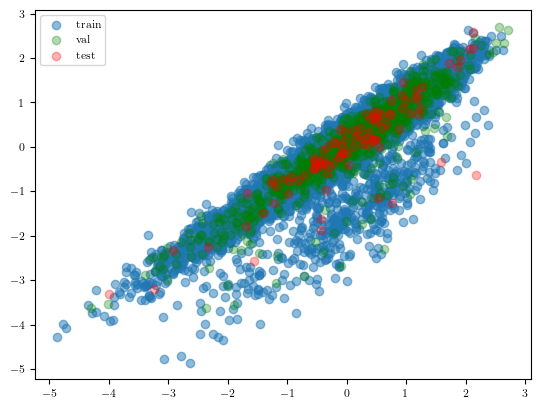

In [5]:
plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

In [6]:
L.seed_everything(0)

lr = 1e-4
gamma = 1e-3
epochs = int(1e3)

MLP_kwargs = {
    'input_shape': X_train.shape[-1],
    'output_shape': 100,
    'n_hidden': 2,
    'layer_size': 256,
    'dropout': 0,
    'iterative_whitening': False
}

optimizer = Adam
optimizer_kwargs = {
    'lr': lr
    }

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': gamma
}

NCP_model = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs, V_operator_kwargs=MLP_kwargs)

X_train_torch = frnp(X_train)
Y_train_torch = frnp(Y_train)
X_val_torch = frnp(X_val)
Y_val_torch = frnp(Y_val)

NCP_module = NCPModule(
    NCP_model,
    optimizer,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs
)

train_dl = DataLoader(XYDataset(X_train_torch, Y_train_torch), batch_size=len(X_train_torch), shuffle=False, num_workers=0)
val_dl = DataLoader(XYDataset(X_val_torch, Y_val_torch), batch_size=len(X_val_torch), shuffle=False, num_workers=0)

trainer = L.Trainer(**{
    'accelerator': 'auto',
    'max_epochs': epochs,
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
    'enable_checkpointing': False,
}, callbacks=[LitProgressBar()])

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 183 K 
--------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.736     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


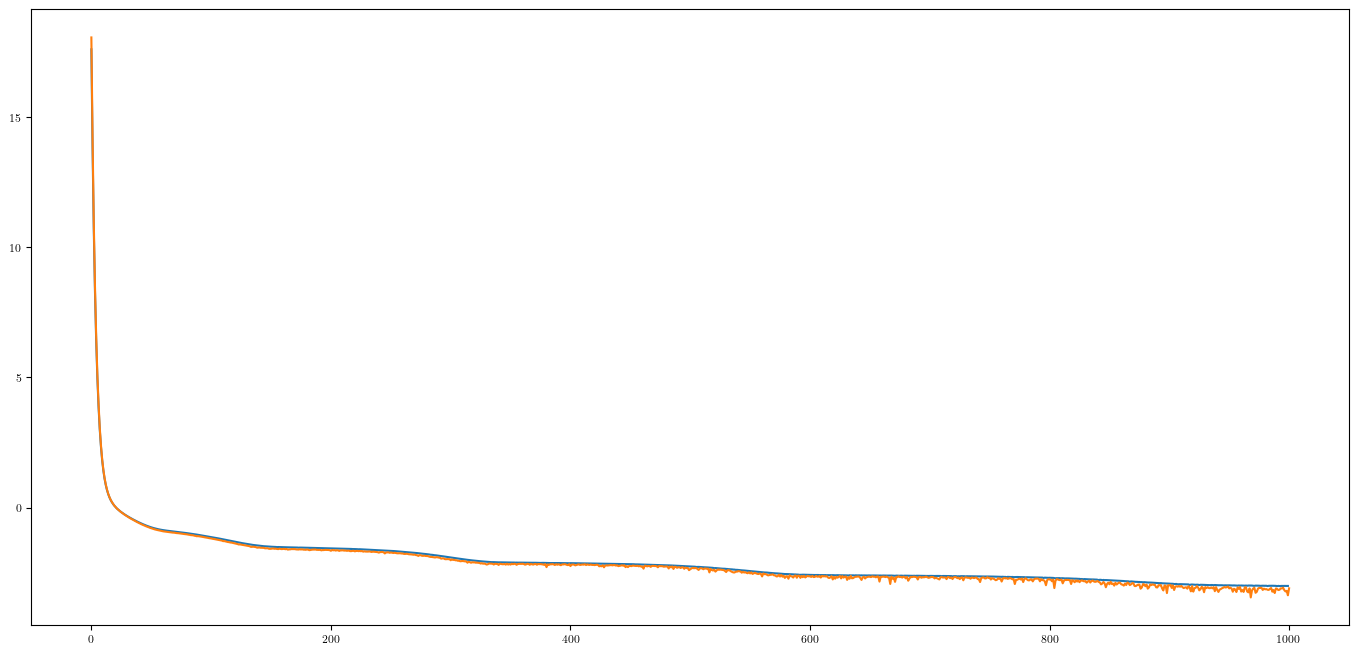

In [8]:
plt.figure(figsize=(17, 8))
plt.plot(range(len(NCP_module.train_loss)), np.array(NCP_module.train_loss))
plt.plot(range(len(NCP_module.val_loss)), np.array(NCP_module.val_loss))
# plt.yscale('log')
plt.show()

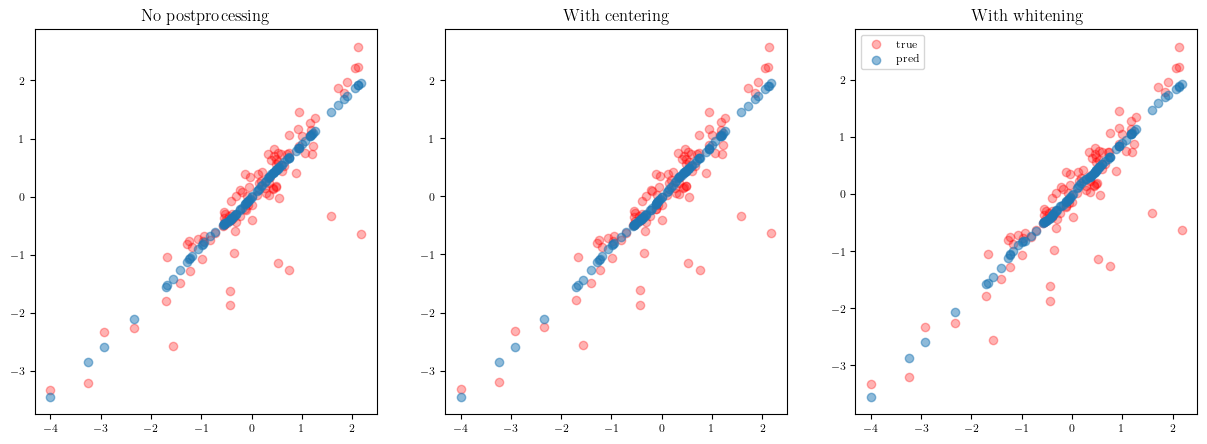

In [9]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

ax=axs[0]
pred = NCP_model.conditional_expectation(frnp(X_test), frnp(Y_train)).reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('No postprocessing')

ax=axs[1]
pred = NCP_model.conditional_expectation(frnp(X_test), frnp(Y_train), postprocess='centering').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With centering')

ax=axs[2]
pred = NCP_model.conditional_expectation(frnp(X_test), frnp(Y_train), postprocess='whitening').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With whitening')

plt.legend()
plt.show()

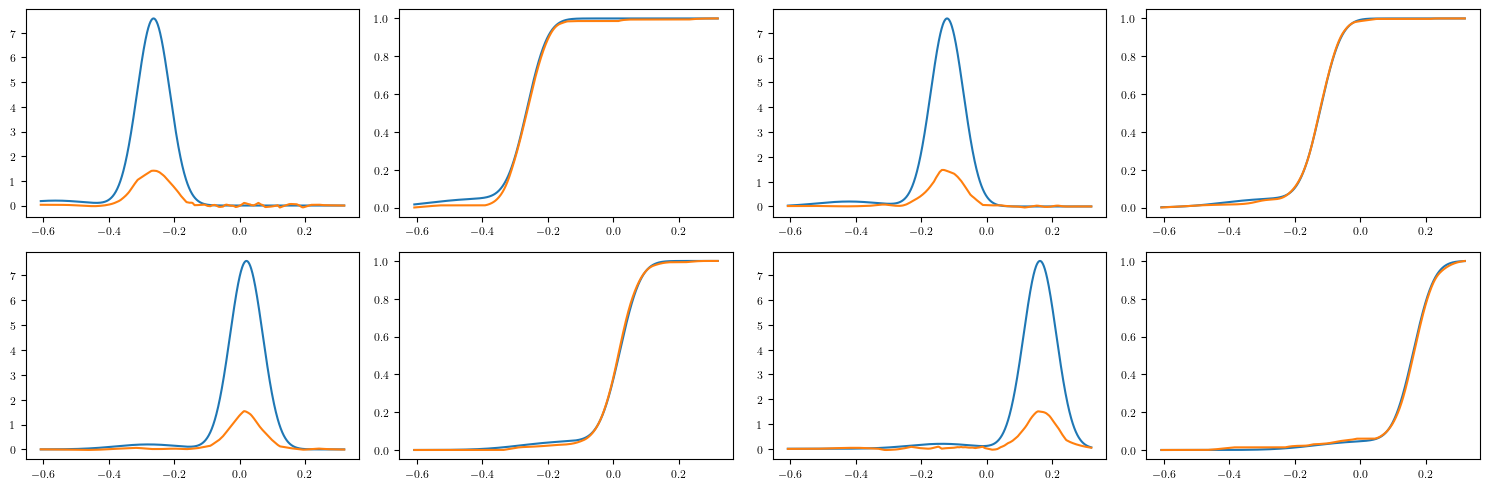

In [10]:
from NCP.cdf import compute_marginal
from NCP.metrics import *

p10, p90 = np.percentile(X_train, [10, 90])
x_grid = np.linspace(p10, p90, num=4)
p1, p99 = np.percentile(Y_train, [1, 99])
ys, step = np.linspace(p1, p99, num=1000, retstep=True)
ys = frnp(ys.reshape(-1, 1))

p_y = compute_marginal(bandwidth='scott').fit(Y_train)

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,5))
axes = ax.flatten()
postprocess = 'whitening'
for i, xi in enumerate(x_grid):
    fys, pred_pdf = NCP_model.pdf(frnp([[xi]]), frnp(ys), postprocess=postprocess, p_y=p_y)
    fys = fys.reshape(-1, 1)
    true_pdf = density_simulator.pdf(xscaler.inverse_transform([[xi]]), yscaler.inverse_transform(ys).T).squeeze()
    axes[i*2].plot(yscaler.inverse_transform(fys), true_pdf)
    axes[i*2].plot(yscaler.inverse_transform(fys), pred_pdf)

    pred_cdf = pdf2cdf(pred_pdf, step)
    true_cdf = density_simulator.cdf(xscaler.inverse_transform([[xi]]), yscaler.inverse_transform(ys).T).squeeze()
    axes[i*2+1].plot(yscaler.inverse_transform(fys), true_cdf)
    axes[i*2+1].plot(yscaler.inverse_transform(fys), smooth_cdf(fys, pred_cdf))

    # axes[i*2].set_title(r'x = {0}; H = {1:0.4f}'.format(xi, hellinger(true_pdf, pred_pdf, fys)))
    # axes[i*2+1].set_title(r'x = {0}; H = {1:0.4f}'.format(xi, hellinger(true_cdf, pred_cdf, fys)))

plt.tight_layout()
plt.show()

In [11]:
p10, p90 = np.percentile(X_train, [10, 90])
x_grid = np.linspace(p10, p90, num=20)
p1, p99 = np.percentile(Y_train, [1, 99])
ys, step = np.linspace(p1, p99, num=1000, retstep=True)
ys = frnp(ys.reshape(-1, 1))

postprocess = 'whitening'
scores = []
for xi in x_grid:
    fys, pred_pdf = NCP_model.pdf(frnp([[xi]]), frnp(ys), postprocess=postprocess, p_y=p_y)
    pred_cdf = pdf2cdf(pred_pdf, step)
    true_cdf = density_simulator.cdf(xscaler.inverse_transform([[xi]]), yscaler.inverse_transform(ys).T).squeeze()
    
    result = compute_metrics(true_cdf.squeeze(), pred_cdf.squeeze(), metrics='all', smooth=True, values=fys.squeeze())
    result['x'] = xi
    
    scores.append(result)

In [12]:
scores = pd.DataFrame(scores)
print(scores.mean())

hellinger             0.665788
wasserstein1          0.008439
kolmogorov_smirnov    0.029644
total_variation       4.219514
jensen_shannon_dv     0.519517
x                    -0.096221
dtype: float64


In [13]:
scores = pd.DataFrame(scores)
print(scores.median())

hellinger             0.568841
wasserstein1          0.006729
kolmogorov_smirnov    0.026364
total_variation       3.364552
jensen_shannon_dv     0.283850
x                    -0.096221
dtype: float64


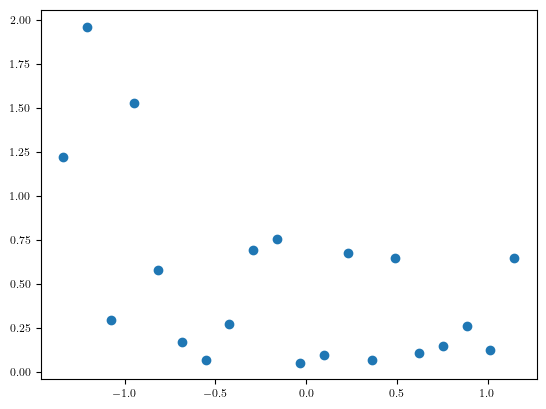

In [14]:
plt.scatter(x_grid.squeeze(), np.array(scores.jensen_shannon_dv))

In [15]:
n_training_samples = [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
lr = 1e-4
gamma = 1e-3
epochs = int(1e3)

models = []
for n in n_training_samples:
    print(f'Running with {n} samples')
    X, Y = density_simulator.simulate(n_samples = n+1000)
    X = X.reshape((-1, 1))
    Y = Y.reshape((-1, 1))
    xscaler = StandardScaler()
    yscaler = StandardScaler()
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=1000, random_state=0)
    X_train = xscaler.fit_transform(X_train)
    Y_train = yscaler.fit_transform(Y_train)
    X_val = xscaler.transform(X_val)
    Y_val = yscaler.transform(Y_val)

    X_train_torch = frnp(X_train)
    Y_train_torch = frnp(Y_train)
    X_val_torch = frnp(X_val)
    Y_val_torch = frnp(Y_val)

    optimizer_kwargs = {
        'lr': lr
        }

    NCP_module = NCPModule(
        NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs, V_operator_kwargs=MLP_kwargs),
        Adam,
        optimizer_kwargs,
        CMELoss,
        loss_kwargs
    )
    
    train_dl = DataLoader(XYDataset(X_train_torch, Y_train_torch), batch_size=len(X_train_torch), shuffle=False, num_workers=0)
    val_dl = DataLoader(XYDataset(X_val_torch, Y_val_torch), batch_size=len(X_val_torch), shuffle=False, num_workers=0)

    trainer = L.Trainer(**{
    'accelerator': 'cuda',
    'max_epochs': epochs,
    'log_every_n_steps': 0,
    'enable_progress_bar': False,
    'devices': 1,
    'enable_checkpointing': False,
    })
    
    trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)
    
    models.append({
        'n_samples': n,
        'model': [NCP_module]
    })
    
    #print last training and validation loss
    print('Training loss: {0}'.format(NCP_module.train_loss[-1]))
    print('Validation loss: {0}'.format(NCP_module.val_loss[-1]))

models_df = pd.DataFrame(models)
models_df.to_pickle('ARMA_models.pkl')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Running with 100 samples


HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 183 K 
--------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.736     Total estimated model params size (MB)
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

Training loss: -3.2214388847351074
Validation loss: 25.03606605529785
Running with 200 samples


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 183 K 
--------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.736     Total estimated model params size (MB)
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not hav

Training loss: -3.8691604137420654
Validation loss: -1.7649521827697754
Running with 500 samples


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 183 K 
--------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.736     Total estimated model params size (MB)
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not hav

Training loss: -2.571539878845215
Validation loss: -2.184260606765747
Running with 1000 samples


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 183 K 
--------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.736     Total estimated model params size (MB)
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not hav

Training loss: -3.132730722427368
Validation loss: -3.0376946926116943
Running with 2000 samples


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 183 K 
--------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.736     Total estimated model params size (MB)
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not hav

Training loss: -2.740489959716797
Validation loss: -2.7543418407440186
Running with 5000 samples


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 183 K 
--------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.736     Total estimated model params size (MB)
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not hav

Training loss: -3.1023099422454834
Validation loss: -2.924377202987671
Running with 10000 samples


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 183 K 
--------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.736     Total estimated model params size (MB)
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not hav

Training loss: -3.06675386428833
Validation loss: -3.0090572834014893
Running with 20000 samples


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 183 K 
--------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.736     Total estimated model params size (MB)
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not hav

Training loss: -3.0001027584075928
Validation loss: -2.7359368801116943
Running with 50000 samples


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training loss: -3.0707240104675293
Validation loss: -3.036184310913086
Running with 100000 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 183 K 
--------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.736     Total estimated model params size (MB)
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider

Training loss: -2.958024263381958
Validation loss: -3.160775661468506


In [16]:
models_df = pd.read_pickle('ARMA_models.pkl')

results = []
for row in tqdm(models_df.iterrows(), total=len(models_df), desc='Evaluating models'):
    n = row[1]['n_samples']
    model = row[1]['model'][0].model
    
    p10, p90 = np.percentile(X_train, [10, 90])
    x_grid = np.linspace(p10, p90, num=10)
    
    p10, p90 = np.percentile(Y_train, [1, 99])
    ys, step = np.linspace(p1, p99, num=1000, retstep=True)
    ys = frnp(ys.reshape(-1, 1))

    for postprocess in [None, 'centering', 'whitening']:
        scores = []
        for xi in x_grid:
            fys, pred_pdf = model.pdf(frnp([[xi]]), frnp(ys), postprocess=postprocess, p_y=p_y)
            pred_cdf = pdf2cdf(pred_pdf, step)
            true_cdf = density_simulator.cdf(xscaler.inverse_transform([[xi]]), yscaler.inverse_transform(ys).T).squeeze()
            
            computed_metrics = compute_metrics(true_cdf.squeeze(), pred_cdf.squeeze(), metrics='all', smooth=True, values=fys.squeeze())
            computed_metrics['x'] = xi
            
            scores.append(computed_metrics)

        result = {
            'n_samples': n,
            'postprocess': str(postprocess),
        }
        
        scores = pd.DataFrame(scores)
        for key in scores:
            result[key] = [scores[key].values]
        
        results.append(result)

Evaluating models:   0%|          | 0/10 [00:00<?, ?it/s]

In [17]:
results_df = pd.DataFrame(results)
results_df.to_pickle('ARMA_results.pkl')

In [27]:
results_df = pd.read_pickle('ARMA_results.pkl')
#take results_pd, group by n_samples and postprocess, apply np.mean and np.std to scores_pdf and create a new dataframe with the results
grouped_results= pd.DataFrame(results_df.groupby(['n_samples', 'postprocess'])['hellinger'].apply(lambda x: np.mean(list(x))))
grouped_results.rename(columns={'hellinger': 'mean_H'}, inplace=True)
grouped_results['median_H'] = results_df.groupby(['n_samples', 'postprocess'])['hellinger'].apply(lambda x: np.median(list(x)))
grouped_results['std_H'] = results_df.groupby(['n_samples', 'postprocess'])['hellinger'].apply(lambda x: np.std(list(x)))
grouped_results['mean_W1'] = results_df.groupby(['n_samples', 'postprocess'])['wasserstein1'].apply(lambda x: np.mean(list(x)))
grouped_results['median_W1'] = results_df.groupby(['n_samples', 'postprocess'])['wasserstein1'].apply(lambda x: np.median(list(x)))
grouped_results['std_W1'] = results_df.groupby(['n_samples', 'postprocess'])['wasserstein1'].apply(lambda x: np.std(list(x)))
grouped_results['mean_KS'] = results_df.groupby(['n_samples', 'postprocess'])['kolmogorov_smirnov'].apply(lambda x: np.mean(list(x)))
grouped_results['median_KS'] = results_df.groupby(['n_samples', 'postprocess'])['kolmogorov_smirnov'].apply(lambda x: np.median(list(x)))
grouped_results['std_KS'] = results_df.groupby(['n_samples', 'postprocess'])['kolmogorov_smirnov'].apply(lambda x: np.std(list(x)))
grouped_results['mean_TV'] = results_df.groupby(['n_samples', 'postprocess'])['total_variation'].apply(lambda x: np.mean(list(x)))
grouped_results['median_TV'] = results_df.groupby(['n_samples', 'postprocess'])['total_variation'].apply(lambda x: np.median(list(x)))
grouped_results['std_TV'] = results_df.groupby(['n_samples', 'postprocess'])['total_variation'].apply(lambda x: np.std(list(x)))
grouped_results['mean_JS'] = results_df.groupby(['n_samples', 'postprocess'])['jensen_shannon_dv'].apply(lambda x: np.mean(list(x)))
grouped_results['median_JS'] = results_df.groupby(['n_samples', 'postprocess'])['jensen_shannon_dv'].apply(lambda x: np.mean(list(x)))
grouped_results['std_JS'] = results_df.groupby(['n_samples', 'postprocess'])['jensen_shannon_dv'].apply(lambda x: np.std(list(x)))
grouped_results = grouped_results.reset_index()
print(grouped_results)

    n_samples postprocess    mean_H  median_H     std_H   mean_W1  median_W1  \
0         100        None  1.880171  1.996897  0.371787  0.039871   0.042128   
1         100   centering  1.881490  1.985181  0.349892  0.039937   0.042398   
2         100   whitening  2.046287  2.092035  0.910567  0.042117   0.032619   
3         200        None  1.734977  1.708011  0.458686  0.028236   0.028876   
4         200   centering  1.721757  1.700731  0.455222  0.028659   0.029603   
5         200   whitening  1.683240  1.438146  0.752096  0.033946   0.032967   
6         500        None  1.418006  1.351232  0.200092  0.029161   0.027740   
7         500   centering  1.505056  1.322838  0.454277  0.027892   0.027056   
8         500   whitening  1.392280  1.262082  0.716449  0.018395   0.017949   
9        1000        None  1.403631  1.445451  0.538991  0.023440   0.023334   
10       1000   centering  1.467738  1.512370  0.603648  0.023275   0.022871   
11       1000   whitening  1.066172  0.9

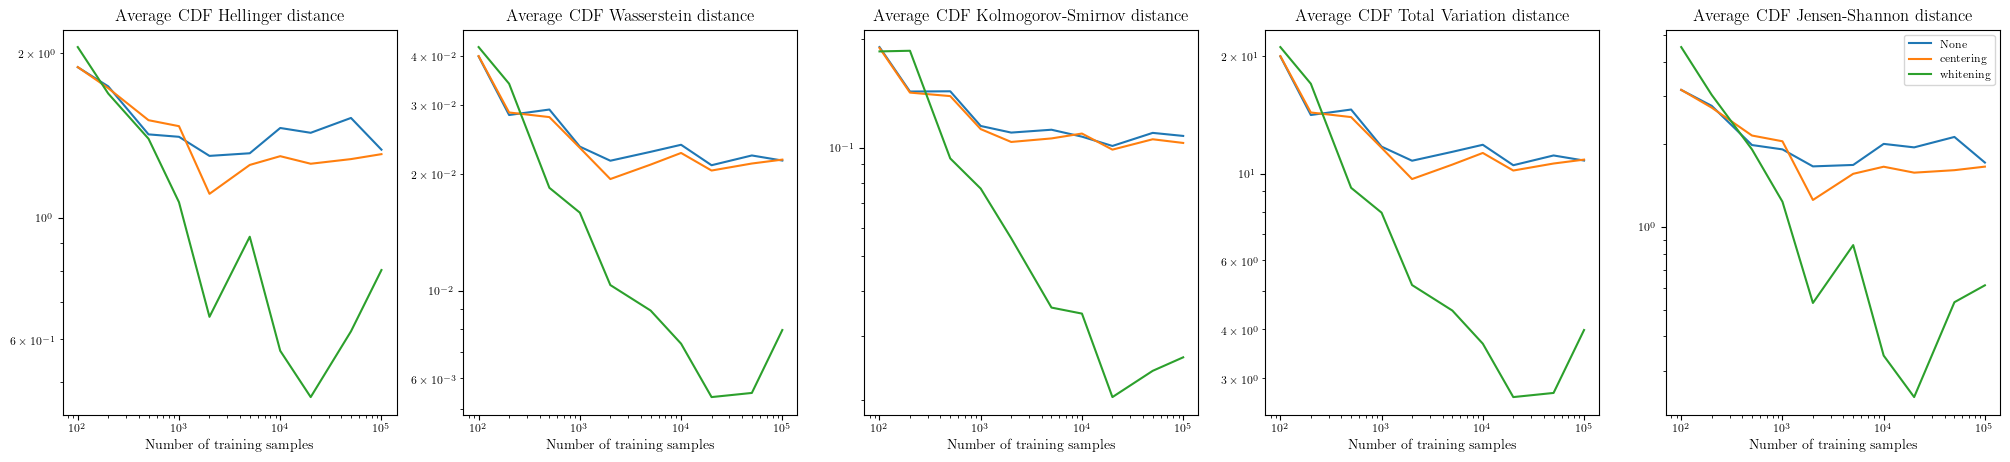

In [28]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))

for postprocess in ['None', 'centering', 'whitening']:
    ax = axs[0]
    n_samples = grouped_results[grouped_results['postprocess'] == postprocess]['n_samples']
    mean_score = grouped_results[grouped_results['postprocess'] == postprocess]['mean_H']
    std_score = grouped_results[grouped_results['postprocess'] == postprocess]['std_H']
    ax.plot(n_samples, mean_score, label=postprocess)
    # ax.fill_between(n_samples, mean_score - std_score, mean_score + std_score, alpha=0.2)
    ax.set_title('Average CDF Hellinger distance')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of training samples')

    ax = axs[1]
    mean_score = grouped_results[grouped_results['postprocess'] == postprocess]['mean_W1']
    std_score = grouped_results[grouped_results['postprocess'] == postprocess]['std_W1']
    ax.plot(n_samples, mean_score, label=postprocess)
    # ax.fill_between(n_samples, mean_score - std_score, mean_score + std_score, alpha=0.2)
    ax.set_title('Average CDF Wasserstein distance')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of training samples')
    
    ax = axs[2]
    mean_score = grouped_results[grouped_results['postprocess'] == postprocess]['mean_KS']
    std_score = grouped_results[grouped_results['postprocess'] == postprocess]['std_KS']
    ax.plot(n_samples, mean_score, label=postprocess)
    # ax.fill_between(n_samples, mean_score - std_score, mean_score + std_score, alpha=0.2)
    ax.set_title('Average CDF Kolmogorov-Smirnov distance')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of training samples')


    ax = axs[3]
    mean_score = grouped_results[grouped_results['postprocess'] == postprocess]['mean_TV']
    std_score = grouped_results[grouped_results['postprocess'] == postprocess]['std_TV']
    ax.plot(n_samples, mean_score, label=postprocess)
    # ax.fill_between(n_samples, mean_score - std_score, mean_score + std_score, alpha=0.2)
    ax.set_title('Average CDF Total Variation distance')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of training samples')

    ax = axs[4]
    mean_score = grouped_results[grouped_results['postprocess'] == postprocess]['mean_JS']
    std_score = grouped_results[grouped_results['postprocess'] == postprocess]['std_JS']
    ax.plot(n_samples, mean_score, label=postprocess)
    # ax.fill_between(n_samples, mean_score - std_score, mean_score + std_score, alpha=0.2)
    ax.set_title('Average CDF Jensen-Shannon distance')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of training samples')


plt.legend()
plt.show()

## SkewNormal

In [29]:
density_simulator = SkewNormal(random_seed=0)
X, Y = density_simulator.simulate(n_samples = Ntrain+Nval+Ntest)

X = X.reshape((-1, 1))
Y = Y.reshape((-1, 1))

xscaler = StandardScaler()
yscaler = StandardScaler()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=Ntest, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=Nval, random_state=0)

X_train = xscaler.fit_transform(X_train)
Y_train = yscaler.fit_transform(Y_train)
X_test = xscaler.transform(X_test)
Y_test = yscaler.transform(Y_test)
X_val = xscaler.transform(X_val)
Y_val = yscaler.transform(Y_val)

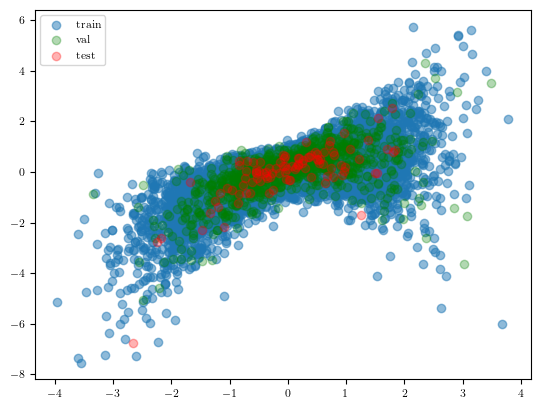

In [30]:
plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

In [31]:
L.seed_everything(0)

lr = 1e-4
gamma = 1e-3
epochs = int(1e3)

MLP_kwargs = {
    'input_shape': X_train.shape[-1],
    'output_shape': 100,
    'n_hidden': 2,
    'layer_size': 256,
    'dropout': 0,
    'iterative_whitening': False
}

optimizer = Adam
optimizer_kwargs = {
    'lr': lr
    }

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': gamma
}

NCP_model = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs, V_operator_kwargs=MLP_kwargs)

X_train_torch = frnp(X_train)
Y_train_torch = frnp(Y_train)
X_val_torch = frnp(X_val)
Y_val_torch = frnp(Y_val)

NCP_module = NCPModule(
    NCP_model,
    optimizer,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs
)

train_dl = DataLoader(XYDataset(X_train_torch, Y_train_torch), batch_size=len(X_train_torch), shuffle=False, num_workers=0)
val_dl = DataLoader(XYDataset(X_val_torch, Y_val_torch), batch_size=len(X_val_torch), shuffle=False, num_workers=0)

trainer = L.Trainer(**{
    'accelerator': 'auto',
    'max_epochs': epochs,
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
    'enable_checkpointing': False,
}, callbacks=[LitProgressBar()])

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [32]:
trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 183 K 
--------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.736     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


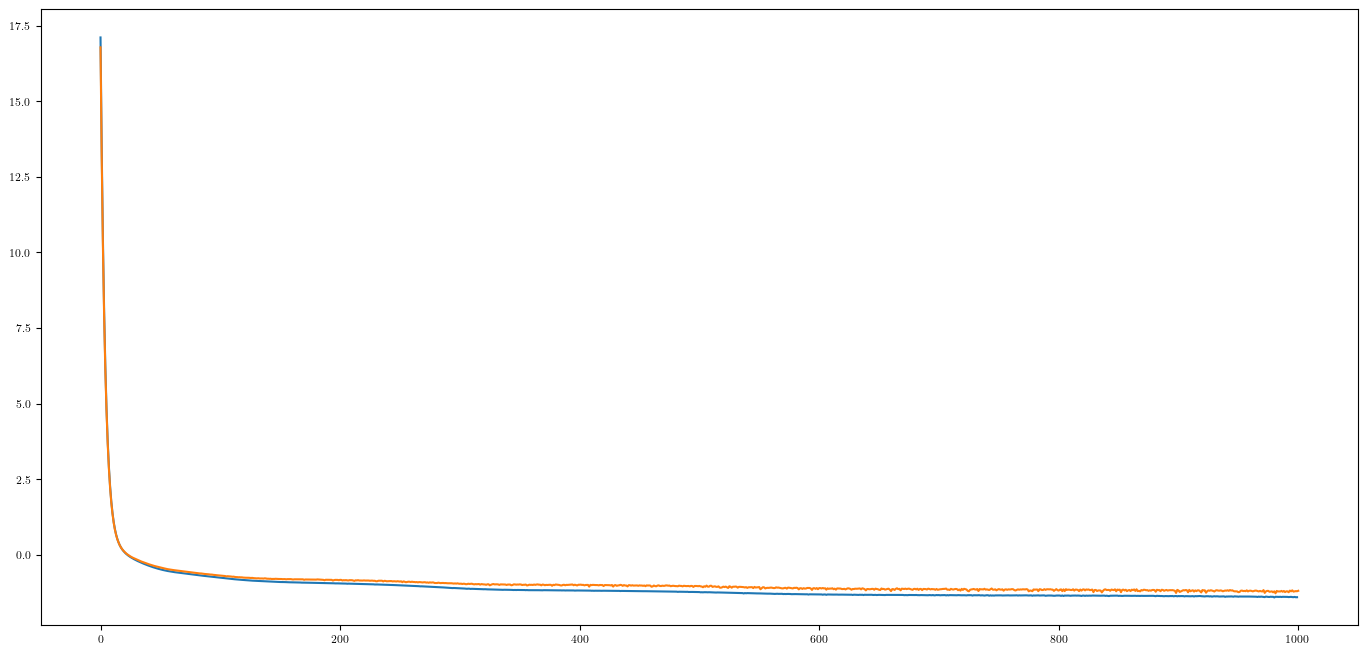

In [33]:
plt.figure(figsize=(17, 8))
plt.plot(range(len(NCP_module.train_loss)), np.array(NCP_module.train_loss))
plt.plot(range(len(NCP_module.val_loss)), np.array(NCP_module.val_loss))
# plt.yscale('log')
plt.show()

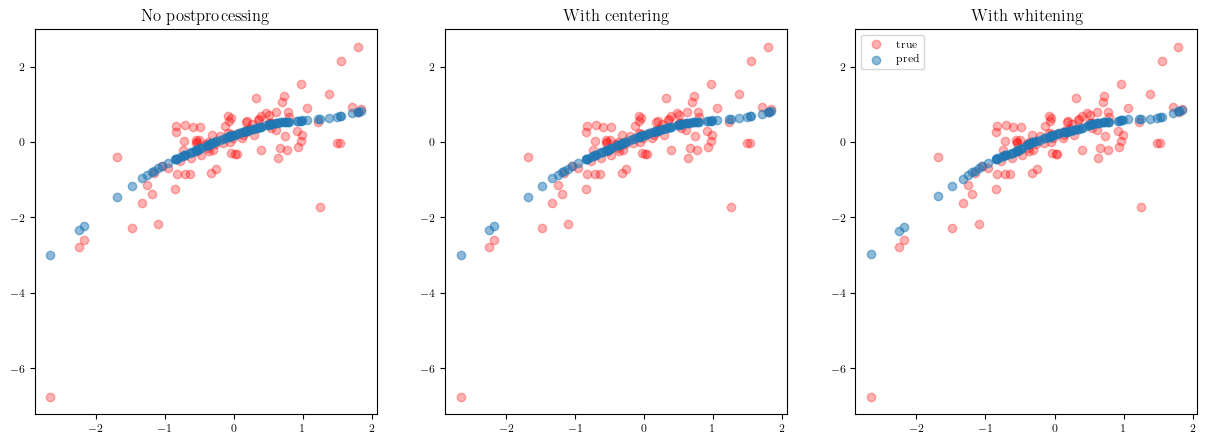

In [34]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

ax=axs[0]
pred = NCP_model.conditional_expectation(frnp(X_test), frnp(Y_train)).reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('No postprocessing')

ax=axs[1]
pred = NCP_model.conditional_expectation(frnp(X_test), frnp(Y_train), postprocess='centering').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With centering')

ax=axs[2]
pred = NCP_model.conditional_expectation(frnp(X_test), frnp(Y_train), postprocess='whitening').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With whitening')

plt.legend()
plt.show()

In [ ]:
from scipy.interpolate import interp1d

class HistogramPDF:
    def __init__(self, data, bins='auto'):
        self.data = data
        self.counts, self.bin_edges = np.histogram(data, bins=bins, density=True)
        self.cdf = np.cumsum(self.counts)
        self.cdf = self.cdf / self.cdf[-1]
        self.pdf = interp1d(self.bin_edges[1:], self.counts, kind='linear', fill_value="extrapolate")

    def __call__(self, x):
        return self.pdf(x)

In [ ]:
p_y = HistogramPDF(Y_train, bins=100)
'gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', \
                 'cosine'

from scipy.stats import gaussian_kde

In [ ]:
p_y = HistogramPDF(Y_train, bins=100)
tmp = p_y(np.linspace(-6, 6, num=1000))
plt.plot(np.linspace(-6, 6, num=1000), tmp)

p_y = compute_marginal(bandwidth='scott', kernel='gaussian').fit(Y_train)
tmp = p_y(np.linspace(-6, 6, num=1000))
plt.plot(np.linspace(-6, 6, num=1000), tmp)

p_y = gaussian_kde(Y_train.squeeze(), bw_method='scott')
tmp = p_y(np.linspace(-6, 6, num=1000))
plt.plot(np.linspace(-6, 6, num=1000), tmp/np.std(tmp))

plt.show()

In [ ]:
p_y = gaussian_kde(Y_train.squeeze(), bw_method='scott')

In [ ]:
from NCP.cdf import compute_marginal
from NCP.metrics import *

ys, step = np.linspace(-3, 3, num=1000, retstep=True)
ys = frnp(ys.reshape(-1, 1))

p_y = compute_marginal(bandwidth='scott').fit(Y_train)

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,5))
axes = ax.flatten()
postprocess = 'whitening'
for i, xi in enumerate([0, 0.5, -0.5, 1]):
    x_scaled = frnp(xscaler.transform([[xi]]))
    fys, pred_pdf = NCP_model.pdf(x_scaled, ys, postprocess=postprocess, p_y=p_y)
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()
    true_pdf = density_simulator.pdf(np.array([[xi]]), fys.reshape([1, -1])).squeeze()
    axes[i*2].plot(fys, true_pdf)
    axes[i*2].plot(fys, pred_pdf)

    pred_cdf = pdf2cdf(pred_pdf, step)
    true_cdf = density_simulator.cdf(np.array([[xi]]), yscaler.inverse_transform(ys).T).squeeze()
    axes[i*2+1].plot(fys, true_cdf)
    axes[i*2+1].plot(fys, pred_cdf)

    axes[i*2].set_title(r'x = {0}; H = {1:0.4f}'.format(xi, hellinger(true_pdf, pred_pdf, fys)))
    axes[i*2+1].set_title(r'x = {0}; H = {1:0.4f}'.format(xi, hellinger(true_cdf, pred_cdf, fys)))

plt.tight_layout()
plt.show()

In [ ]:
p10, p90 = np.percentile(X_train, [10, 90])
x_grid = np.linspace(p10, p90, num=20)
ys, step = np.linspace(-3, 3, num=1000, retstep=True)
ys = frnp(ys.reshape(-1, 1))

postprocess = 'centering'
scores_pdf = []
scores_cdf = []
for el in x_grid:
    fys, pred_pdf = NCP_module.model.pdf(frnp([[el]]), ys, postprocess=postprocess, p_y=p_y)
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()
    true_pdf = density_simulator.pdf(xscaler.inverse_transform([[el]]), yscaler.inverse_transform(ys).T).squeeze()
    pred_cdf = pdf2cdf(pred_pdf, step)
    true_cdf = density_simulator.cdf(xscaler.inverse_transform([[el]]), yscaler.inverse_transform(ys).T).squeeze()
    scores_pdf.append(hellinger(true_pdf, pred_pdf, fys))
    scores_cdf.append(hellinger(true_cdf, pred_cdf, fys))

In [ ]:
print('Mean pdf hellinger distance: {0:.4f}'.format(np.mean(scores_pdf)))
print('Median pdf hellinger distance: {0:.4f}'.format(np.median(scores_pdf)))
print('Mean cdf hellinger distance: {0:.4f}'.format(np.mean(scores_cdf)))
print('Median cdf hellinger distance: {0:.4f}'.format(np.median(scores_cdf)))

In [ ]:
plt.scatter(x_grid.squeeze(), np.array(scores_cdf))

In [ ]:
n_training_samples = [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
lr = 1e-3
gamma = 1e-2
epochs = int(1e3)
models = []
for n in n_training_samples:
    print(f'Running with {n} samples')
    X, Y = density_simulator.simulate(n_samples = n+1000)
    X = X.reshape((-1, 1))
    Y = Y.reshape((-1, 1))
    xscaler = StandardScaler()
    yscaler = StandardScaler()
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=1000, random_state=0)
    X_train = xscaler.fit_transform(X_train)
    Y_train = yscaler.fit_transform(Y_train)
    X_val = xscaler.transform(X_val)
    Y_val = yscaler.transform(Y_val)

    X_train_torch = frnp(X_train)
    Y_train_torch = frnp(Y_train)
    X_val_torch = frnp(X_val)
    Y_val_torch = frnp(Y_val)

    optimizer_kwargs = {
        'lr': lr
        }

    NCP_module = NCPModule(
        NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs, V_operator_kwargs=MLP_kwargs),
        Adam,
        optimizer_kwargs,
        CMELoss,
        loss_kwargs
    )
    
    train_dl = DataLoader(XYDataset(X_train_torch, Y_train_torch), batch_size=len(X_train_torch), shuffle=False, num_workers=0)
    val_dl = DataLoader(XYDataset(X_val_torch, Y_val_torch), batch_size=len(X_val_torch), shuffle=False, num_workers=0)

    trainer = L.Trainer(**{
    'accelerator': 'cuda',
    'max_epochs': epochs,
    'log_every_n_steps': 0,
    'enable_progress_bar': False,
    'devices': 1,
    'enable_checkpointing': False,
    })

    trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)
    
    models.append({
        'n_samples': n,
        'model': [NCP_module]
    })
    
    #print last training and validation loss
    print('Training loss: {0}'.format(NCP_module.train_loss[-1]))
    print('Validation loss: {0}'.format(NCP_module.val_loss[-1]))

models_df = pd.DataFrame(models)
models_df.to_pickle('Skew_models.pkl')

In [ ]:
results = []
for row in tqdm(models_df.iterrows(), total=len(models_df), desc='Evaluating models'):
    n = row[1]['n_samples']
    model = row[1]['model'][0].model
    p10, p90 = np.percentile(X_train, [10, 90])
    x_grid = np.linspace(p10, p90, num=20)
    ys, step = np.linspace(-3, 3, num=1000, retstep=True)
    ys = frnp(ys.reshape(-1, 1))

    for postprocess in [None, 'centering', 'whitening']:
        scores_pdf = []
        scores_cdf = []
        for el in x_grid:
            fys, pred_pdf = model.pdf(frnp([[el]]), ys, postprocess=postprocess, p_y=p_y)
            fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()
            true_pdf = density_simulator.pdf(xscaler.inverse_transform([[el]]), yscaler.inverse_transform(ys).T).squeeze()
            pred_cdf = pdf2cdf(pred_pdf, step)
            true_cdf = density_simulator.cdf(xscaler.inverse_transform([[el]]), yscaler.inverse_transform(ys).T).squeeze()
            scores_pdf.append(hellinger(true_pdf, pred_pdf, fys))
            scores_cdf.append(hellinger(true_cdf, pred_cdf, fys))

        result = {
            'n_samples': n,
            'postprocess': str(postprocess),
            'scores_pdf': scores_pdf,
            'scores_cdf': scores_cdf
        }
        results.append(result)

In [ ]:
results_df = pd.DataFrame(results)
results_df.to_pickle('Skew.pkl')

In [ ]:
results_df

In [ ]:
results_df = pd.read_pickle('Skew.pkl')
#take results_pd, group by n_samples and postprocess, apply np.mean and np.std to scores_pdf and create a new dataframe with the results
grouped_results= pd.DataFrame(results_df.groupby(['n_samples', 'postprocess'])['scores_cdf'].apply(lambda x: np.mean(list(x))))
grouped_results.rename(columns={'scores_cdf': 'mean_scores_cdf'}, inplace=True)
grouped_results['std_scores_cdf'] = results_df.groupby(['n_samples', 'postprocess'])['scores_cdf'].apply(lambda x: np.std(list(x)))
grouped_results['mean_scores_pdf'] = results_df.groupby(['n_samples', 'postprocess'])['scores_pdf'].apply(lambda x: np.mean(list(x)))
grouped_results['std_scores_pdf'] = results_df.groupby(['n_samples', 'postprocess'])['scores_pdf'].apply(lambda x: np.std(list(x)))
grouped_results = grouped_results.reset_index()
print(grouped_results)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for postprocess in ['None', 'centering', 'whitening']:
    ax = axs[0]
    n_samples = grouped_results[grouped_results['postprocess'] == postprocess]['n_samples']
    mean_score = grouped_results[grouped_results['postprocess'] == postprocess]['mean_scores_pdf']
    std_score = grouped_results[grouped_results['postprocess'] == postprocess]['std_scores_pdf']
    ax.plot(n_samples, mean_score, label=postprocess)
    ax.fill_between(n_samples, mean_score - std_score, mean_score + std_score, alpha=0.3)
    ax.set_title('Average PDF Hellinger distance')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of training samples')

    ax = axs[1]
    mean_score = grouped_results[grouped_results['postprocess'] == postprocess]['mean_scores_cdf']
    std_score = grouped_results[grouped_results['postprocess'] == postprocess]['std_scores_cdf']
    ax.plot(n_samples, mean_score, label=postprocess)
    ax.fill_between(n_samples, mean_score - std_score, mean_score + std_score, alpha=0.3)
    ax.set_title('Average CDF Hellinger distance')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of training samples')

plt.legend()
plt.show()

## Gaussian Mixture

In [4]:
sigma_sq = 1

Ntrain = int(1e4)
Nval = int(1e3)
Ntest = int(1e2)

ndim_x = 1
ndim_y = 1
density_simulator = GaussianMixture(n_kernels=5, ndim_x=ndim_x, ndim_y=ndim_y, means_std=1.5, random_seed=0)
X, Y = density_simulator.simulate(n_samples = Ntrain+Nval+Ntest)
X = X.reshape((-1, 1))
Y = Y.reshape((-1, 1))

xscaler = StandardScaler()
yscaler = StandardScaler()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=Ntest, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=Nval, random_state=0)

X_train = xscaler.fit_transform(X_train)
Y_train = yscaler.fit_transform(Y_train)
X_test = xscaler.transform(X_test)
Y_test = yscaler.transform(Y_test)
X_val = xscaler.transform(X_val)
Y_val = yscaler.transform(Y_val)

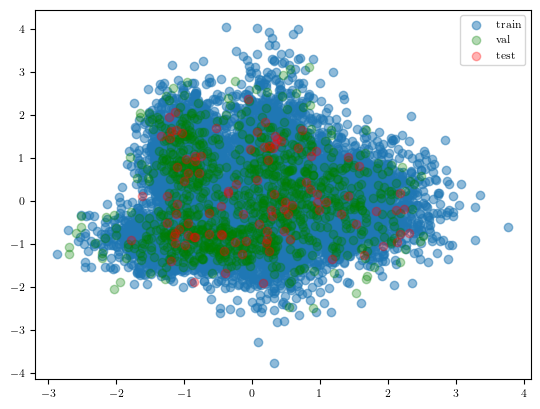

In [5]:
plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

In [14]:
L.seed_everything(0)

lr = 1e-4
gamma = 1e-3
epochs = int(2e3)

MLP_kwargs = {
    'input_shape': X_train.shape[-1],
    'output_shape': 100,
    'n_hidden': 2,
    'layer_size': 256,
    'dropout': 0,
    'iterative_whitening': False
}

optimizer = Adam
optimizer_kwargs = {
    'lr': lr
    }

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': gamma
}

NCP_model = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs, V_operator_kwargs=MLP_kwargs)

X_train_torch = frnp(X_train)
Y_train_torch = frnp(Y_train)
X_val_torch = frnp(X_val)
Y_val_torch = frnp(Y_val)

NCP_module = NCPModule(
    NCP_model,
    optimizer,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs
)

train_dl = DataLoader(XYDataset(X_train_torch, Y_train_torch), batch_size=len(X_train_torch), shuffle=False, num_workers=0)
val_dl = DataLoader(XYDataset(X_val_torch, Y_val_torch), batch_size=len(X_val_torch), shuffle=False, num_workers=0)

trainer = L.Trainer(**{
    'accelerator': 'auto',
    'max_epochs': epochs,
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
    'enable_checkpointing': False,
    'num_sanity_val_steps': 0,
    'enable_model_summary': True,
}, callbacks=[LitProgressBar()])

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 183 K 
--------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.736     Total estimated model params size (MB)


0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2000` reached.


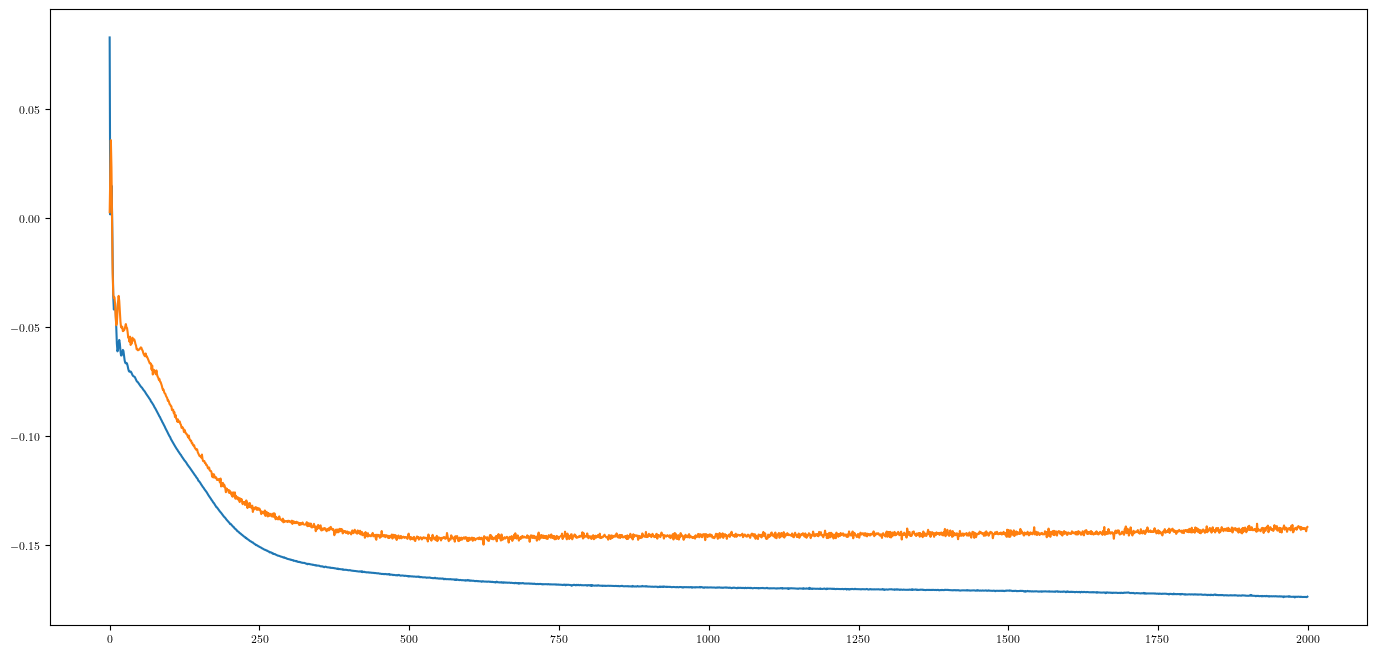

In [16]:
plt.figure(figsize=(17, 8))
plt.plot(range(len(NCP_module.train_loss)), np.array(NCP_module.train_loss))
plt.plot(range(len(NCP_module.val_loss)), np.array(NCP_module.val_loss))
# plt.yscale('log')
plt.show()

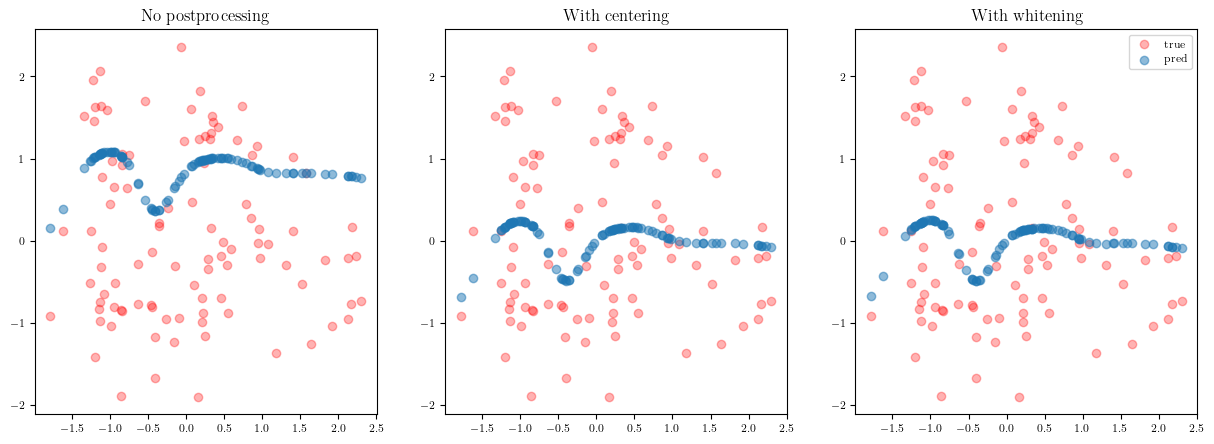

In [17]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

ax=axs[0]
pred = NCP_model.conditional_expectation(frnp(X_test), frnp(Y_train)).reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('No postprocessing')

ax=axs[1]
pred = NCP_model.conditional_expectation(frnp(X_test), frnp(Y_train), postprocess='centering').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With centering')

ax=axs[2]
pred = NCP_model.conditional_expectation(frnp(X_test), frnp(Y_train), postprocess='whitening').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With whitening')

plt.legend()
plt.show()

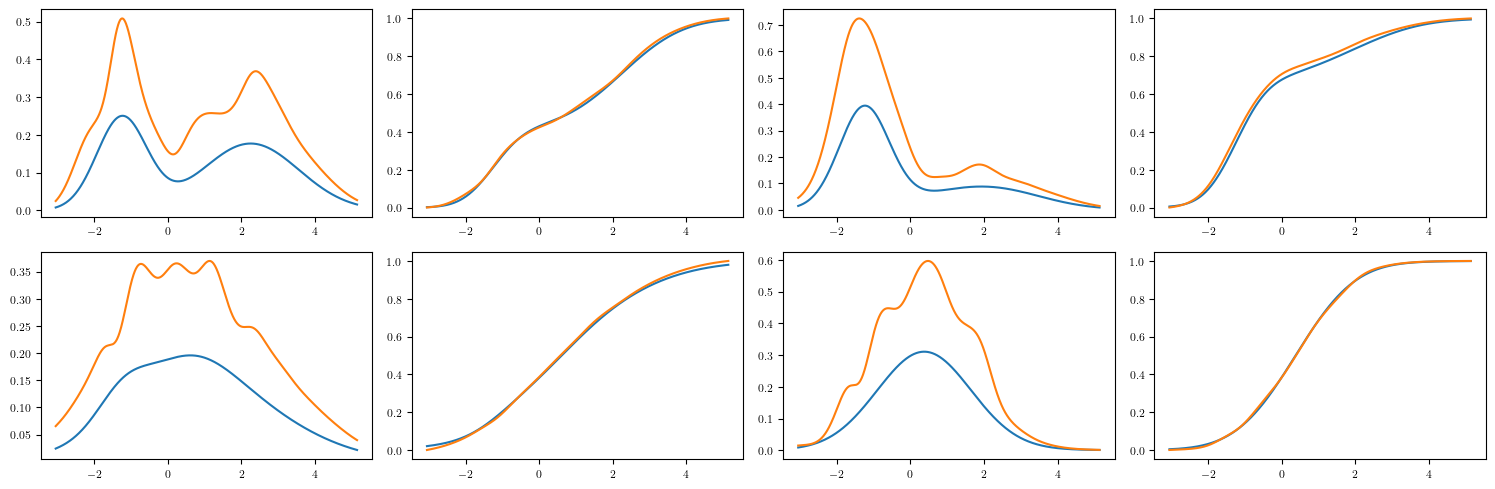

In [18]:
from NCP.cdf import compute_marginal
from NCP.metrics import *

x_grid = np.percentile(X_train, np.linspace(10, 90, num=4))
p1, p99 = np.percentile(Y_train, [1, 99])
ys, step = np.linspace(p1, p99, num=1000, retstep=True)
ys = frnp(ys.reshape(-1, 1))
p_y = compute_marginal(bandwidth='scott').fit(Y_train)

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,5))
axes = ax.flatten()
postprocess = 'whitening'
for i, xi in enumerate(x_grid):
    fys, pred_pdf = NCP_model.pdf(frnp([[xi]]), frnp(ys), postprocess=postprocess, p_y=p_y)
    fys = fys.reshape(-1, 1)
    true_pdf = density_simulator.pdf(xscaler.inverse_transform(np.ones_like(ys)*xi), yscaler.inverse_transform(ys)).squeeze()
    axes[i*2].plot(yscaler.inverse_transform(fys), true_pdf)
    axes[i*2].plot(yscaler.inverse_transform(fys), pred_pdf)

    pred_cdf = pdf2cdf(pred_pdf, step)
    true_cdf = density_simulator.cdf(xscaler.inverse_transform(np.ones_like(ys)*xi), yscaler.inverse_transform(ys)).squeeze()
    axes[i*2+1].plot(yscaler.inverse_transform(fys), true_cdf)
    axes[i*2+1].plot(yscaler.inverse_transform(fys), smooth_cdf(fys, pred_cdf))

    # axes[i*2].set_title(r'x = {0}; H = {1:0.4f}'.format(xi, hellinger(true_pdf, pred_pdf, fys)))
    # axes[i*2+1].set_title(r'x = {0}; H = {1:0.4f}'.format(xi, hellinger(true_cdf, pred_cdf, fys)))

plt.tight_layout()
plt.show()

In [22]:
x_grid = np.percentile(X_train, np.linspace(10, 90, num=10))
p1, p99 = np.percentile(Y_train, [1, 99])
ys, step = np.linspace(p1, p99, num=1000, retstep=True)
ys = frnp(ys.reshape(-1, 1))

postprocess = 'whitening'
scores = []
for xi in x_grid:
    fys, pred_pdf = NCP_model.pdf(frnp([[xi]]), frnp(ys), postprocess=postprocess, p_y=p_y)
    pred_cdf = pdf2cdf(pred_pdf, step)
    true_cdf = density_simulator.cdf(xscaler.inverse_transform(np.ones_like(ys)*xi), yscaler.inverse_transform(ys))
    result = compute_metrics(true_cdf.squeeze(), pred_cdf.squeeze(), metrics='all', smooth=True, values=fys.squeeze())
    result['x'] = xi
    
    scores.append(result)

In [23]:
scores = pd.DataFrame(scores)
print(scores.mean())

hellinger             0.351122
wasserstein1          0.008349
kolmogorov_smirnov    0.021060
total_variation       4.174455
jensen_shannon_dv     0.132531
x                    -0.026135
dtype: float64


In [24]:
scores = pd.DataFrame(scores)
print(scores.median())

hellinger             0.346585
wasserstein1          0.006633
kolmogorov_smirnov    0.019787
total_variation       3.316723
jensen_shannon_dv     0.117187
x                    -0.020169
dtype: float64


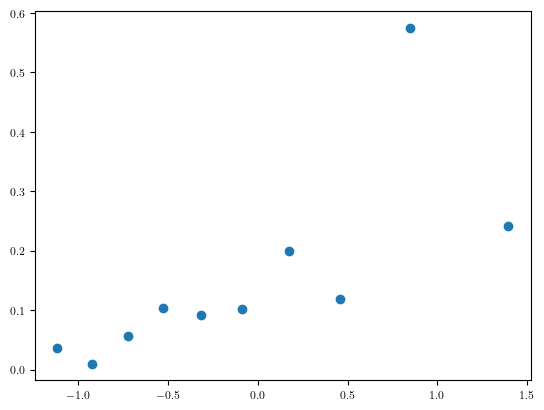

In [15]:
plt.scatter(x_grid.squeeze(), np.array(scores.jensen_shannon_dv))